### Create linear regression model predicting biomass (clipped) from visual obstruction readings (VOR)

#### Imports

In [85]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import ee
import wxee
#import geemap
import xarray as xr
import geopandas as gpd
from rasterio.plot import show
import json
from statsmodels.stats.anova import anova_lm
from scipy.stats import shapiro

In [4]:
# authenticate and initialize Earth Engine for extracting gridded PRISM precip
# only need to authenticate every once in a while - will download a temporary
# authorization token
ee.Authenticate()
wxee.Initialize()

Enter verification code:  4/1AVHEtk4nUiVle9P_pK-UAcsbNuBM090jYcjEYNRp94fcmBlPBjqr8ncQ14M



Successfully saved authorization token.


#### Define helper functions

In [5]:
# custom function to get PRISM precip for a single Earth Engine feature
def get_prism_ppt(feature):
    year = ee.Date(feature.get('Date')).get('year')
    prism_lag = ic_prism.filter(ee.Filter.date(ee.Date(year.subtract(2).format().cat('-10-1')),
                                               ee.Date(year.subtract(1).format().cat('-9-30'))))
    ppt_lag = prism_lag.sum().reduceRegion(ee.Reducer.mean(), feature.geometry(), scale=4638.3).get('ppt')
    prism_current = ic_prism.filter(ee.Filter.date(ee.Date(year.subtract(1).format().cat('-10-1')),
                                                   ee.Date(year.format().cat('-6-1'))))
    ppt_current = prism_current.sum().reduceRegion(ee.Reducer.mean(), feature.geometry(), scale=4638.3).get('ppt')
    feature = feature.set('ppt_lag', ppt_lag).set('ppt_current', ppt_current)
    return feature

#### Load inputs

In [6]:
# load all VOR training datasets
df_nex_vor = pd.read_csv('data/vor_train/TB_nex_vor_train.csv', parse_dates=['Date'])
df_gmdr_vor = pd.read_csv('data/vor_train/TB_gmdr_vor_train.csv', parse_dates=['Date'])
df_wtgn_vor = pd.read_csv('data/vor_train/TB_wtgn_vor_train.csv', parse_dates=['Date'])

# load climate data as potential co-variate
# this is downloaded manually from PRISM as a single point, approximately in the center of TB
df_prism = pd.read_csv('data/prism/TB_PRISM_stable_4km_19810101_20220901_43.2929_-105.1229.csv', skiprows=10)

#### Prep data

In [7]:
# give each dataset a name based on the study
df_nex_vor['study'] = 'NEX'
df_gmdr_vor['study'] = 'GMDR'
df_wtgn_vor['study'] = 'WTGN'

# combine all VOR datasets into one
df_vor = pd.concat([df_nex_vor, 
                    df_gmdr_vor, 
                    df_wtgn_vor], axis=0)

# set date on PRISM dataset
df_prism['Date'] = pd.to_datetime(df_prism['Date'])

# convert VOR DataFrame into a GeoDataFrame
gdf_vor = gpd.GeoDataFrame(data=df_vor,
                           geometry=gpd.points_from_xy(df_vor['Mean.GPS_E.Biomass'],
                                                       df_vor['Mean.GPS_N.Biomass']),
                           crs='EPSG:32613')

In [25]:
# give each plot a unique id
df_vor['id_plot'] = df_vor.apply(lambda x: '_'.join([x['Site'], x['Disturbance'], x['Exclosure']]) if x['study'] == 'NEX' else
                                   '_'.join([x['Pasture'], str(int(x['Plot']))]) if x['study'] == 'WTGN' else
                                   '_'.join([str(int(x['Block'])), str(int(x['Paddock']))]), axis=1)
# give each pasture (i.e., block) a name
df_vor['Pasture'] = df_vor.apply(lambda x: x['Pasture'] if x['study'] == 'WTGN' else
                                   x['Site'], axis=1)

In [12]:
# remove spaces from column names
for c in df_vor.columns:
    if ' ' in c:
        df_vor.rename(columns={c: re.sub(' ', '_', c)}, inplace=True)

In [9]:
# calculate the time difference (days) between the VOR and Biomass measurements
df_vor['Date_diff'] = df_vor['Date'] - pd.to_datetime(df_vor['Date_cln'])
df_vor['Date_diff_days'] = df_vor['Date_diff'].dt.days

In [10]:
# create a new dominant functional group class that uses a 60% threshold instead 
# of a 40% threshold
df_vor['domin_fg_2'] = df_vor.apply(lambda x: 'Mixed' if x['domin_fg_pct'] < 0.60 else x['domin_fg'], axis=1)

#### Explore data

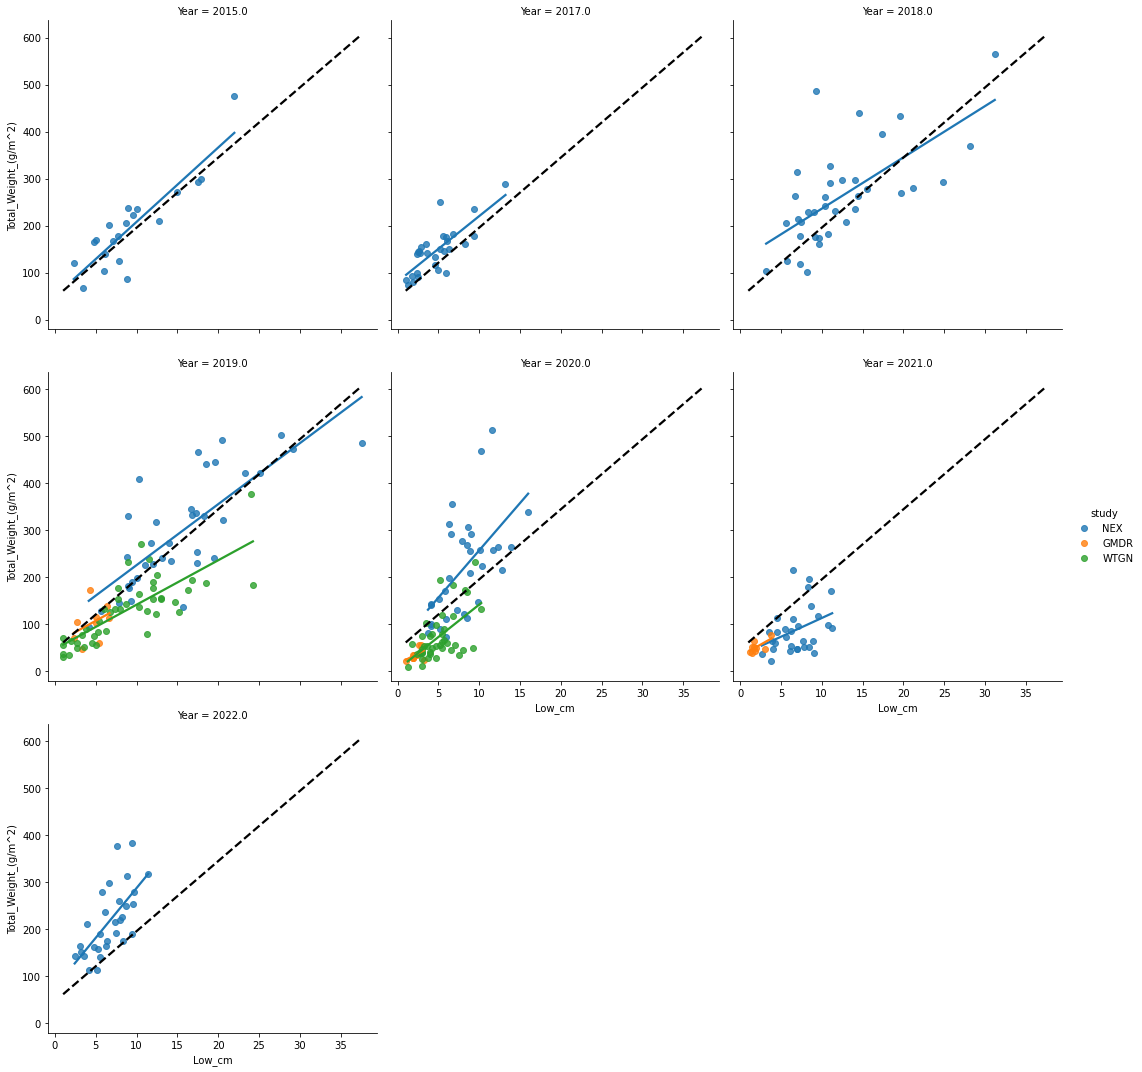

In [28]:
# plot VOR low vs Biomass by Year and study
p = sns.lmplot(data=df_vor, x='Low_cm', y='Total_Weight_(g/m^2)', hue='study', col='Year', col_wrap=3, ci=None)
for ax in p.axes.flatten():
    sns.regplot(data=df_vor, x='Low_cm', y='Total_Weight_(g/m^2)', scatter=False, 
                line_kws={'linestyle': 'dashed', 'color': 'black'}, ax=ax, ci=None, )

<AxesSubplot:xlabel='Low_cm', ylabel='Total_Weight_(g/m^2)'>

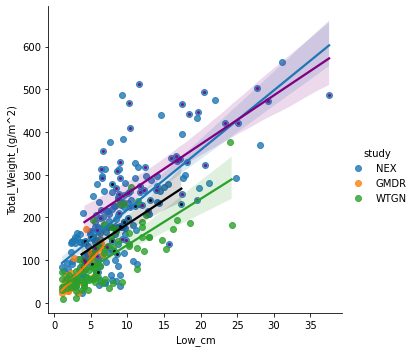

In [27]:
# plot VOR low vs. biomass by study across all years
p = sns.lmplot(data=df_vor, 
           hue='study',
           x='Low_cm', y='Total_Weight_(g/m^2)')
# add the lake creek site (which is spatially lumped with the WTGN sites) as a black line
# only for years where WTGN data available
sns.regplot(data=df_vor[(df_vor['Pasture'] == 'lake creek') &
                        (df_vor['Year'].isin(df_vor[df_vor['study'] == 'WTGN']['Year'].unique()))],
           x='Low_cm', y='Total_Weight_(g/m^2)',
           scatter_kws={'color': 'black', 's': 4}, 
           line_kws={'color': 'black'},
            ax=p.ax)
# add the other NEX sites as a purple line
# only for years when WTGN available
sns.regplot(data=df_vor[(df_vor['Pasture'] != 'lake creek') &
                        (df_vor['study'] == 'NEX') &
                        (df_vor['Year'].isin(df_vor[df_vor['study'] == 'WTGN']['Year'].unique()))],
           x='Low_cm', y='Total_Weight_(g/m^2)',
           scatter_kws={'color': 'purple', 's': 4}, 
           line_kws={'color': 'purple'},
            ax=p.ax)

<AxesSubplot:xlabel='Low_cm', ylabel='Total_Weight_(g/m^2)'>

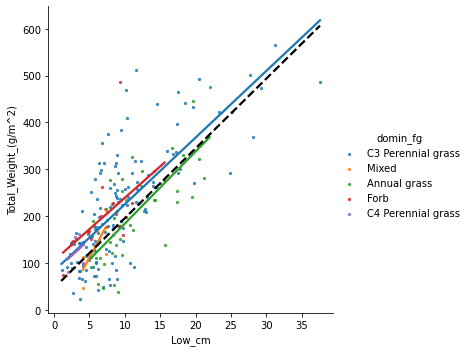

In [13]:
# plot VOR low vs. biomass by dominant functional group
# only done for NEX project, since dominant functional group has not been
# extracted for other projects yet
p = sns.lmplot(data=df_vor[df_vor['study'] == 'NEX'], 
               x='Low_cm', y='Total_Weight_(g/m^2)', hue='domin_fg', palette='tab10',
               scatter_kws={'s': 5}, ci=None)
sns.regplot(data=df_vor, x='Low_cm', y='Total_Weight_(g/m^2)', scatter=False, 
            line_kws={'linestyle': 'dashed', 'color': 'black'}, 
            ax=p.axes[0, 0], ci=None, )

<AxesSubplot:ylabel='Frequency'>

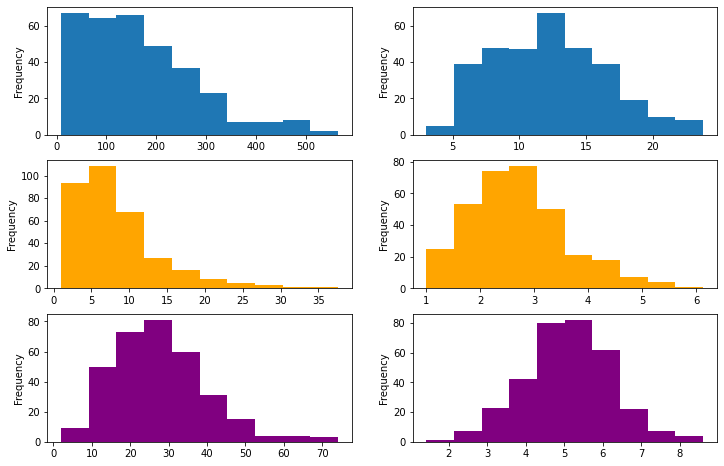

In [50]:
# compare transformed and orignal dependent and independent variables
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 8))
df_vor_mod['Total_Weight_(g/m^2)'].plot.hist(ax=ax[0, 0])
df_vor_mod['Total_Weight_(g/m^2)'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[0, 1])

df_vor_mod['Low_cm'].plot.hist(ax=ax[1, 0], color='orange')
df_vor_mod['Low_cm'].transform(lambda x:  np.power(x, 0.5)).plot.hist(ax=ax[1, 1], color='orange')

df_vor_mod['High_cm'].plot.hist(ax=ax[2, 0], color='purple')
df_vor_mod['High_cm'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[2, 1], color='purple')

#### Predict biomass from VOR using the CPER model

In [29]:
# predict using CPER coefficients, converting to g/m2
df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10
# get residuals
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']

##### Compare CPER model predictions to the fitting the same model to data

In [31]:
# create an empty dataframe to populate
df_mod_results = pd.DataFrame(columns=['dataset', 'R2', 
                                       'TB_MAE', 'TB_MAE_pct',
                                       'CPER_MAE', 'CPER_MAE_pct'])

# loop through each study and refit the model
# then calculate R2, mean absolute error (MAE) and relative error (MAE_pct)
idx=0
for study, grp in df_vor.groupby('study'):
    mod_tmp = smf.ols("Q('Total_Weight_(g/m^2)') ~ Low_cm + High_cm", 
                   data=grp).fit()
    grp['pred_tb'] = mod_tmp.predict()
    grp['resid_tb'] = grp['pred_tb'] - grp['Total_Weight_(g/m^2)']
    mae_tmp = grp.apply(lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']), 
                            axis=1).mean()
    mae_tmp_cper = grp.apply(lambda x: abs(x['pred_cper'] - x['Total_Weight_(g/m^2)']), 
                            axis=1).mean()
    df_mod_results = pd.concat([df_mod_results, (pd.DataFrame({
        'dataset': study,
        'R2': round(mod_tmp.rsquared_adj, 2),
        'TB_MAE': mae_tmp,
        'TB_MAE_pct': round(mae_tmp / grp['Total_Weight_(g/m^2)'].mean() * 100, 2),
        'CPER_MAE': mae_tmp_cper,
        'CPER_MAE_pct': round(mae_tmp_cper / grp['Total_Weight_(g/m^2)'].mean() * 100, 2)},
    index=[idx]))])
    idx += 1

In [32]:
# print the results
df_mod_results

,dataset,R2,TB_MAE,TB_MAE_pct,CPER_MAE,CPER_MAE_pct
0,GMDR,0.56,15.428892,24.70,22.098429,35.38
1,NEX,0.54,55.908926,26.70,57.813242,27.61
2,WTGN,0.58,31.861395,30.97,55.717320,54.15


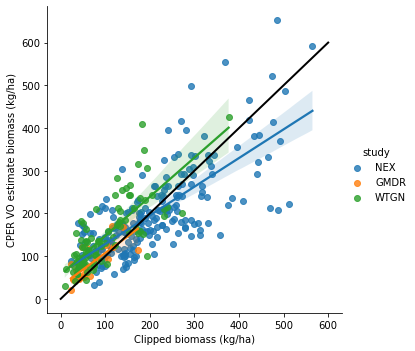

In [45]:
# plot the results of the CPER prediction by study
sns.lmplot(data=df_vor,
            y='pred_cper', x='Total_Weight_(g/m^2)',
           hue='study')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')

#### Fit initial VOR model(s)

##### Additional model prep

In [51]:
# set whether to exclude the weight gain study in the model
exclude_wtgn=False
if exclude_wtgn:
    df_vor_mod = df_vor[df_vor['study'] != 'WTGN'].copy(deep=True)
else:
    df_vor_mod = df_vor.copy(deep=True)
    
# drop 2022 data because not fully QA/QC'd
#df_vor = df_vor[df_vor['Year'] != 2022].copy()

# drop any data where clipped biomass was collected after VOR
#df_vor = df_vor[df_vor['Date_diff_days'] <= 0]

In [54]:
# simple full model
form_simp = "Q('Total_Weight_(g/m^2)') ~ Low_cm + High_cm"
# full model, transform dependent variable
form_dx = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ Low_cm + High_cm"
# full model, transform dependent and independent variables
form_dx_ix = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5)"
# full model, transformed, and interactions
form_dx_ix_intx = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) * np.power(High_cm, 0.5)"

# fit all models
mod_simp = smf.ols(form_simp, data=df_vor_mod).fit()
mod_dx = smf.ols(form_dx, data=df_vor_mod).fit()
mod_dx_ix = smf.ols(form_dx_ix, data=df_vor_mod).fit()
mod_dx_ix_intx = smf.ols(form_dx_ix_intx, data=df_vor_mod).fit()

In [78]:
# calculate and save Adjusted R-Squared and Mean Absolute Error (relative to mean)
df_mods_out = pd.DataFrame({'form': ['Simple', 'DX', 'DX_IX', 'DX_IX_INTX'],
              'R-sq_adj': [round(mod_simp.rsquared_adj, 2),
                           round(mod_dx.rsquared_adj, 2),
                           round(mod_dx_ix.rsquared_adj, 2),
                           round(mod_dx_ix_intx.rsquared_adj, 2)],
              'MAE_pct': [
                  round(np.mean(abs(
                      mod_simp.predict() -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_dx.predict()**2 -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_dx_ix.predict()**2 -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2),
                  round(np.mean(abs(
                      mod_dx_ix_intx.predict()**2 -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2)]
                  })
df_mods_out

,form,R-sq_adj,MAE_pct
0,Simple,0.60,0.32
1,DX,0.58,0.33
2,DX_IX,0.61,0.31
3,DX_IX_INTX,0.61,0.31


In [80]:
# run everything for the low-only model version of the most parsimonious above model
# whic is to transform dependent and independent variables, no interactions
form_dx_ix_low = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5)"
mod_dx_ix_low = smf.ols(form_dx_ix_low, data=df_vor_mod).fit()
df_mods_out = pd.concat([df_mods_out, 
                       pd.DataFrame({'form': ['DX_IX_LOW'],
              'R-sq_adj': [round(mod_dx_ix_low.rsquared_adj, 2)],
              'MAE_pct': [
                  round(np.mean(abs(
                      mod_dx_ix_low.predict()**2 -
                      df_vor_mod['Total_Weight_(g/m^2)'])) / 
                        df_vor_mod['Total_Weight_(g/m^2)'].mean(), 2)]
                  })])
df_mods_out

,form,R-sq_adj,MAE_pct
0,Simple,0.60,0.32
1,DX,0.58,0.33
2,DX_IX,0.61,0.31
3,DX_IX_INTX,0.61,0.31
0,DX_IX_LOW,0.58,0.32


In [83]:
# check if most parsimonious full model is significant different from low-only model
anova_lm(mod_dx_ix_low, mod_dx_ix)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,328.0,2542.653886,0.0,NaN,NaN,NaN
1,327.0,2303.041408,1.0,239.612478,34.021655,1.309835e-08


In [84]:
# print full summary of the best model
mod_dx_ix.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     np.power(Q('Total_Weight_(g/m^2)'), 0.5)   R-squared:                       0.617
Model:                                                  OLS   Adj. R-squared:                  0.614
Method:                                       Least Squares   F-statistic:                     263.1
Date:                                      Wed, 12 Apr 2023   Prob (F-statistic):           8.00e-69
Time:                                              22:46:25   Log-Likelihood:                -788.83
No. Observations:                                       330   AIC:                             1584.
Df Residuals:                                           327   BIC:                             1595.
Df Model:                                                 2                                         
Covariance Type:                                  nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2456      0.684     -0.359      0.720      -1.591       1.100
np.power(Low_cm, 0.5)      2.2978      0.262      8.767      0.000       1.782       2.813
np.power(High_cm, 0.5)     1.2291      0.211      5.833      0.000       0.815       1.644
==============================================================================
Omnibus:                        3.024   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.220   Jarque-Bera (JB):                2.739
Skew:                           0.207   Prob(JB):                        0.254
Kurtosis:                       3.165   Cond. No.                         29.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
# check normality of residuals
df_vor_mod['pred_tb'] = mod_dx_ix.predict()**2
df_vor_mod['resid_tb'] = df_vor_mod['pred_tb'] - df_vor_mod['Total_Weight_(g/m^2)']
shapiro(df_vor_mod['resid_tb'])

ShapiroResult(statistic=0.9599042534828186, pvalue=7.29314777458967e-08)

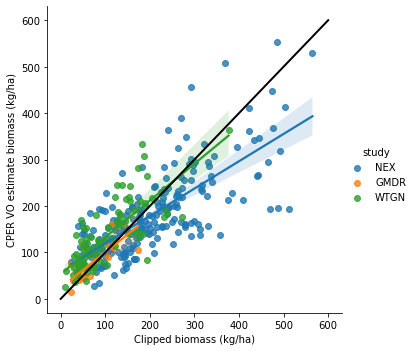

In [88]:
# plot the results of the TB prediction by study
sns.lmplot(data=df_vor_mod,
            y='pred_tb', x='Total_Weight_(g/m^2)',
           hue='study')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')

MAE from TB model:  0.31
MAE from CPER model:  0.32


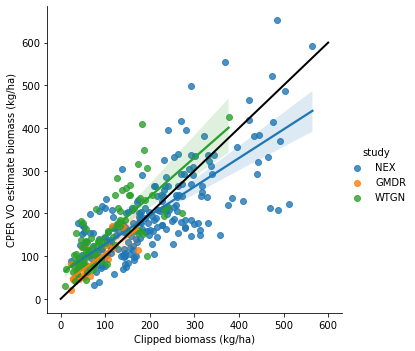

In [94]:
# compare to CPER model predictions
# plot the results of the CPER prediction by study
sns.lmplot(data=df_vor_mod,
            y='pred_cper', x='Total_Weight_(g/m^2)',
           hue='study')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')
# print the overall MAE_pct from both
print('MAE from TB model: ', df_mods_out[df_mods_out['form'] == 'DX_IX']['MAE_pct'].values[0])
print('MAE from CPER model: ', 
      round(np.mean(abs(
          df_vor_mod['pred_cper'] -
          df_vor_mod['Total_Weight_(g/m^2)']) / 
                    df_vor_mod['Total_Weight_(g/m^2)'].mean()), 2))

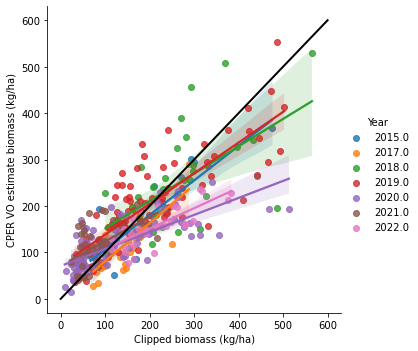

In [95]:
# plot the results of the TB prediction by year
sns.lmplot(data=df_vor_mod,
            y='pred_tb', x='Total_Weight_(g/m^2)',
           hue='Year')
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('CPER VO estimate biomass (kg/ha)')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='solid')

#### Merge with PRISM data

In [ ]:

# merge the universal PRISM data using a single point applied to all of TB
#df_vor = pd.merge_asof(df_vor.sort_values('Date'), 
#                       df_prism[['Date', 'ppt_yr_cumsum']],
#                       left_on='Date',
 #                      right_on='Date',
 #                      direction='nearest',
 #                      tolerance=timedelta(days=1),
 #                      suffixes=['_x', ''],)

# merge the gridded PRISM data, which extracted a unique precip value for each plot location
df_vor = pd.merge(df_vor,
                  gdf_vor[['Date', 'id_plot', 'ppt_yr_cumsum', 'ppt_lag', 'ppt_current']],
                  on=['Date', 'id_plot'])

In [5]:
# drop 
gdf_vor = gdf_vor[gdf_vor['Mean.GPS_E.Biomass'].notnull()].to_crs('EPSG:4269')
gdf_vor['Date'] = gdf_vor['Date'].dt.strftime('%Y-%m-%d')
fc_vor = ee.FeatureCollection(json.loads(gdf_vor[['Date', 'geometry']].to_json()))

In [6]:
ic_prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d')

In [8]:
fc_vor = fc_vor.map(get_prism_ppt)

In [9]:
collection = fc_vor.getInfo()

In [10]:
gdf_vor = pd.merge(gdf_vor, gpd.GeoDataFrame.from_features(collection['features']), how='left', on=['geometry', 'Date'])

In [11]:
gdf_vor['ppt_yr_cumsum'] = (gdf_vor['ppt_lag'] + gdf_vor['ppt_current']) * 0.0393701
gdf_vor['Date'] = pd.to_datetime(gdf_vor['Date'])

<AxesSubplot:xlabel='Date', ylabel='ppt_yr_cumsum'>

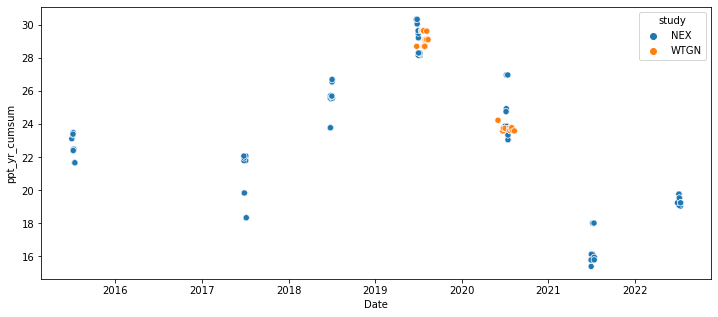

In [16]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x='Date', y='ppt_yr_cumsum', hue='study', data=gdf_vor)

In [25]:
gdf_vor['id_plot'] = gdf_vor.apply(lambda x: '_'.join([x['Site'], x['Disturbance'], x['Exclosure']]) if x['study'] == 'NEX' else
                                   '_'.join([x['Pasture'], str(int(x['Plot']))]) if x['study'] == 'WTGN' else
                                   '_'.join([x['Block'], x['Paddock']]), axis=1)
gdf_vor['Pasture'] = gdf_vor.apply(lambda x: x['Pasture'] if x['study'] == 'WTGN' else
                                   x['Site'], axis=1)

<AxesSubplot:>

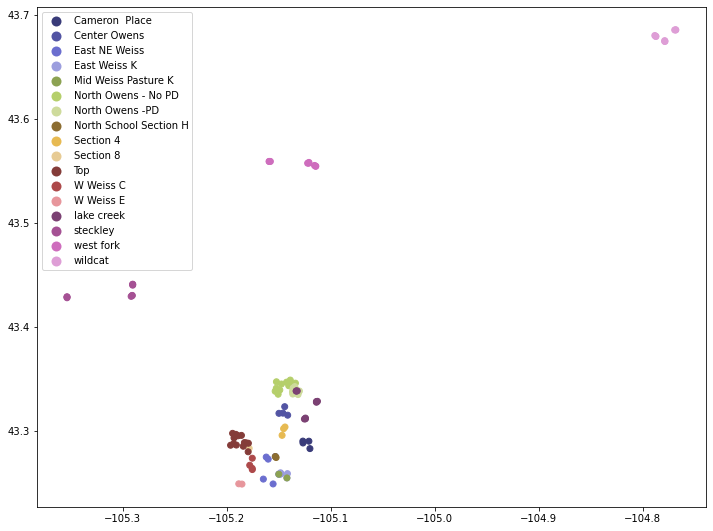

In [26]:
fig,ax = plt.subplots(figsize=(12, 12))
gdf_vor.groupby('id_plot').first().reset_index().plot(column='Pasture', legend=True, ax=ax, cmap='tab20b')
#gdf_vor[gdf_vor['study'] == 'NEX'].groupby('id_plot').first().plot(ax=ax, color='black')

In [332]:
#gdf_vor['id_plot'].unique()

<AxesSubplot:xlabel='Date', ylabel='ppt (inches)'>

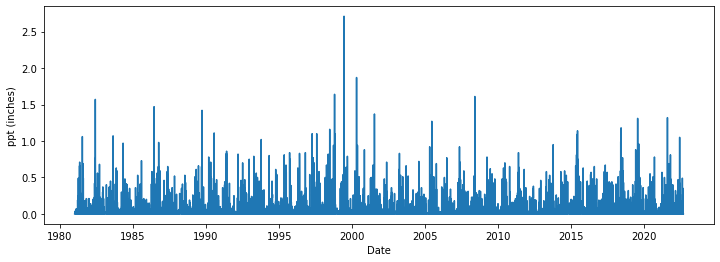

In [27]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_prism, x='Date', y='ppt (inches)')

In [53]:
df_prism['ppt_yr_cumsum'] = df_prism['ppt (inches)'].rolling(window=365+240).sum()
df_prism['ppt_120_cumsum'] = df_prism['ppt (inches)'].rolling(window=120).sum()
df_prism['temp_month_avg'] = df_prism['tmax (degrees F)'].rolling(window=30, center=True).mean()

<AxesSubplot:xlabel='Date', ylabel='ppt_yr_cumsum'>

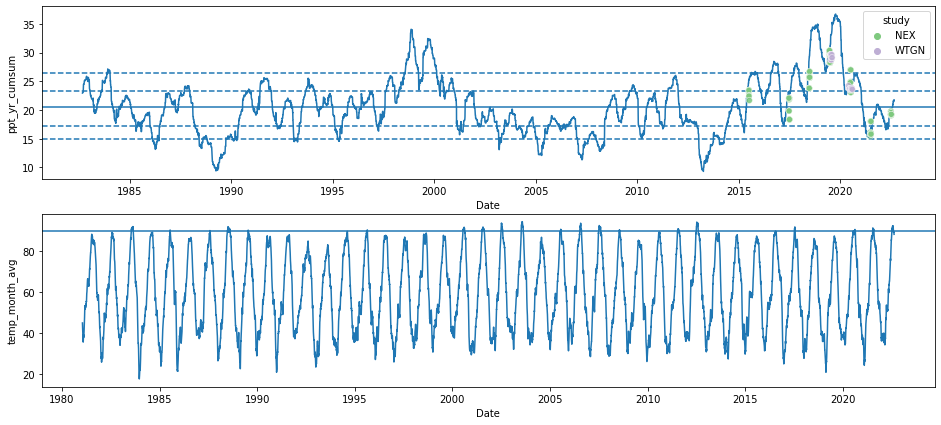

In [29]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 7))
sns.lineplot(data=df_prism, x='Date', y='ppt_yr_cumsum', ax=axs[0])
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].mean())
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].quantile(0.25), linestyle='dashed')
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].quantile(0.75), linestyle='dashed')
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].quantile(0.1), linestyle='dashed')
axs[0].axhline(y=df_prism['ppt_yr_cumsum'].quantile(0.9), linestyle='dashed')
sns.lineplot(data=df_prism, x='Date', y='temp_month_avg', ax=axs[1])
axs[1].axhline(y=90)
sns.scatterplot(x='Date', y='ppt_yr_cumsum', data=gdf_vor, ax=axs[0], hue='study', palette='Accent', zorder=10, alpha=0.5)

In [50]:
df_vor[df_vor['Year'] == 2020].groupby([pd.Grouper(key='Date', freq='W'), 'Pasture']).mean()['ppt_yr_cumsum']

Date        Pasture        
2020-06-07  W Weiss E          24.240879
2020-06-28  Center Owens       23.598320
            North Owens -PD    23.760249
2020-07-05  North Owens -PD    23.760249
            lake creek         23.816371
2020-07-12  lake creek         23.781102
            steckley           24.800263
            wildcat            26.985172
2020-07-19  west fork          23.159527
            wildcat            26.985172
2020-07-26  East Weiss K       23.628477
            W Weiss C          23.788674
2020-08-02  Top                23.755350
            W Weiss C          23.788674
2020-08-09  Section 4          23.598320
2020-08-16  Section 4          23.598320
Name: ppt_yr_cumsum, dtype: float64

In [54]:
ppt_bins = [0,
            #df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].quantile(.1), 
            df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].quantile(.25),
            df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].quantile(.75), 
            df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].quantile(.9),
            df_prism['ppt_yr_cumsum'][df_prism['Date'].dt.month.isin([6, 7, 8])].max()*1.01]

df_vor['ppt_binned'] = pd.cut(df_vor['ppt_yr_cumsum'], ppt_bins)

In [264]:
ppt_yr_bins = [0,
            df_vor['ppt_yr_cumsum'].quantile(.25),
            df_vor['ppt_yr_cumsum'].quantile(.75), 
            df_vor['ppt_yr_cumsum'].quantile(.9),
            df_vor['ppt_yr_cumsum'].max()*1.01]

df_vor['ppt_yr_binned'] = pd.cut(df_vor['ppt_yr_cumsum'], ppt_yr_bins)


ppt_lag_bins = [0,
            df_vor['ppt_lag'].quantile(.25),
            df_vor['ppt_lag'].quantile(.75), 
            df_vor['ppt_lag'].quantile(.9),
            df_vor['ppt_lag'].max()*1.01]

df_vor['ppt_lag_binned'] = pd.cut(df_vor['ppt_lag'], ppt_lag_bins)

ppt_current_bins = [0,
            df_vor['ppt_current'].quantile(.25),
            df_vor['ppt_current'].quantile(.75), 
            df_vor['ppt_current'].quantile(.9),
            df_vor['ppt_current'].max()*1.01]

df_vor['ppt_current_binned'] = pd.cut(df_vor['ppt_current'], ppt_current_bins)

In [60]:
df_vor['ppt_current_binned'].value_counts()

(139.66, 222.428]     157
(0.0, 139.66]          77
(222.428, 272.207]     40
(272.207, 298.59]      30
Name: ppt_current_binned, dtype: int64

In [61]:
high_bins = [0,
             #df_vor['High_cm'].quantile(0.1),
            df_vor['High_cm'].quantile(0.25),
            #df_vor['High_cm'].quantile(0.4),
            #df_vor['High_cm'].quantile(0.6),
            df_vor['High_cm'].quantile(0.75),
             #df_vor['High_cm'].quantile(0.9),
            df_vor['High_cm'].max()+1]
df_vor['High_cm_binned'] = pd.cut(df_vor['High_cm'], high_bins)

In [62]:
# set whether to exclude the Weight Gains (WTGN) study
exclude_wtgn = False

In [63]:
# Check the number of observations per year
df_vor.groupby('Year').count()

,Site,Disturbance,Exclosure,Date,Date_cln,High_cm,Low_cm,Area (m^2),Total Weight (g),Total Weight (g/m^2),...,Pasture,vor_reading_ct,id_plot,ppt_yr_cumsum,ppt_lag,ppt_current,ppt_binned,ppt_lag_binned,ppt_current_binned,High_cm_binned
Year,,,,,,,,,,,,,,,,,,,,,
2015.0,20,20,20,20,20,20,20,20,20,20,...,20,0,20,20,20,20,20,20,20,20
2017.0,29,29,29,29,29,29,29,29,29,29,...,29,0,29,29,29,29,29,29,29,29
2018.0,36,36,36,36,36,36,36,36,36,36,...,36,0,36,36,36,36,36,36,36,36
2019.0,36,36,36,81,36,81,81,36,36,81,...,81,45,81,81,81,81,81,81,81,81
2020.0,33,33,33,76,33,76,76,33,33,76,...,76,43,76,76,76,76,76,76,76,76
2021.0,30,30,30,30,30,30,30,30,30,30,...,30,0,30,30,30,30,30,30,30,30
2022.0,32,32,32,32,32,32,32,32,32,32,...,32,0,32,32,32,32,32,32,32,32


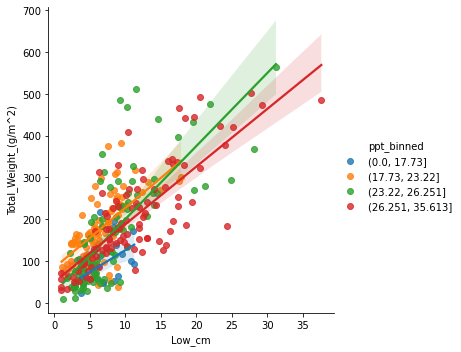

In [153]:
p = sns.lmplot(data=df_vor, 
           hue='ppt_binned',
           x='Low_cm', 
               y='Total_Weight_(g/m^2)', order=1)

<AxesSubplot:xlabel='ppt_yr_cumsum', ylabel='Total_Weight_(g/m^2)'>

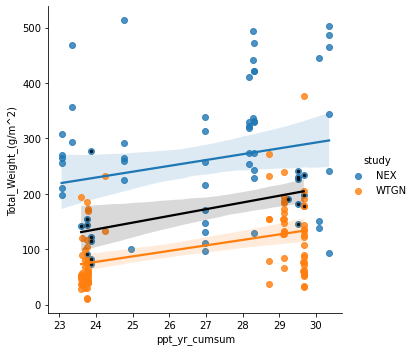

In [119]:
p = sns.lmplot(data=df_vor[df_vor['Year'].isin(df_vor[df_vor['study'] == 'WTGN']['Year'].unique())], 
           hue='study',
           x='ppt_yr_cumsum', y='Total_Weight_(g/m^2)')
sns.regplot(data=df_vor[(df_vor['Pasture'] == 'lake creek') &
                        (df_vor['Year'].isin(df_vor[df_vor['study'] == 'WTGN']['Year'].unique()))],
           x='ppt_yr_cumsum', y='Total_Weight_(g/m^2)',
           scatter_kws={'color': 'black', 's': 6}, 
           line_kws={'color': 'black'},
            ax=p.ax)

In [309]:
#form = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5) + ppt_binned"
#form = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5) + ppt_yr_binned"
#form = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5) + ppt_lag_binned"
#form = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5) + np.power(High_cm, 0.5) + ppt_current_binned"
mod_both = smf.ols(form, 
                   data=df_vor_mod).fit()
df_vor_mod['pred_tb'] = mod_both.predict()**2
df_vor_mod['resid_tb'] = df_vor_mod['pred_tb'] - df_vor_mod['Total_Weight_(g/m^2)']

In [310]:
from statsmodels.stats.anova import anova_lm
form_low = "np.power(Q('Total_Weight_(g/m^2)'), 0.5) ~ np.power(Low_cm, 0.5)"
mod_low = smf.ols(form_low, 
                   data=df_vor_mod).fit()
anova_lm(mod_low, mod_both)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,302.0,2456.280643,0.0,NaN,NaN,NaN
1,300.0,2237.719174,2.0,218.561469,14.65073,8.494535e-07


In [311]:
from scipy.stats import shapiro
shapiro(df_vor_mod['resid_tb'])

ShapiroResult(statistic=0.9647775292396545, pvalue=9.605972763893078e-07)

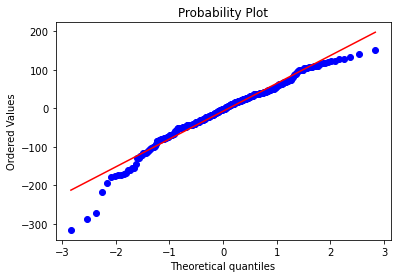

In [312]:
import pylab 
import scipy.stats as stats

stats.probplot(df_vor_mod['resid_tb'], dist="norm", plot=pylab)
pylab.show()

In [313]:
mod_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     np.power(Q('Total_Weight_(g/m^2)'), 0.5)   R-squared:                       0.572
Model:                                                  OLS   Adj. R-squared:                  0.567
Method:                                       Least Squares   F-statistic:                     133.4
Date:                                      Tue, 04 Apr 2023   Prob (F-statistic):           6.50e-55
Time:                                              10:01:13   Log-Likelihood:                -734.78
No. Observations:                                       304   AIC:                             1478.
Df Residuals:                                           300   BIC:                             1492.
Df Model:                                                 3                                         
Covariance Type:                                  nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -1.2661      1.986     -0.638      0.524      -5.174       2.641
np.power(Low_cm, 0.5)                            2.7615      0.789      3.501      0.001       1.209       4.314
np.power(High_cm, 0.5)                           1.4466      0.393      3.684      0.000       0.674       2.219
np.power(Low_cm, 0.5):np.power(High_cm, 0.5)    -0.0878      0.125     -0.704      0.482      -0.333       0.158
==============================================================================
Omnibus:                        1.125   Durbin-Watson:                   1.591
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                1.023
Skew:                           0.142   Prob(JB):                        0.600
Kurtosis:                       3.017   Cond. No.                         248.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [314]:
df_vor_mod.apply(lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']), 
                            axis=1).mean() / df_vor_mod['Total_Weight_(g/m^2)'].mean()

0.3108913966176912

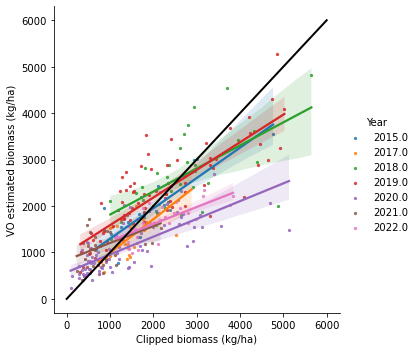

In [307]:
df_vor_mod['pred_tb_kg'] = df_vor_mod['pred_tb']*10
df_vor_mod['Total_Weight_(kg/ha)'] = df_vor_mod['Total_Weight_(g/m^2)']*10
sns.lmplot(y='pred_tb_kg',
           x='Total_Weight_(kg/ha)',
           data=df_vor_mod,
           hue='Year',
           #line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
           #scatter_kws={'color': 'black', 's': 5}
           scatter_kws={'s': 5}
          )
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('VO estimated biomass (kg/ha)')
plt.plot([0, 6000], [0, 6000], linewidth=2, c='black', linestyle='solid')

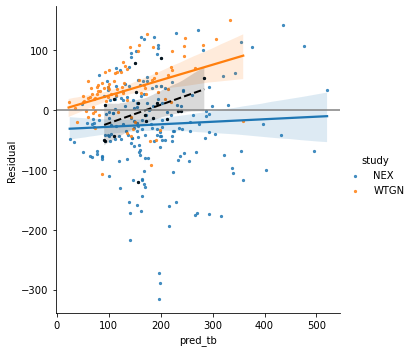

In [324]:
p = sns.lmplot(y='resid_tb',
           x='pred_tb',
           hue='study',
           data=df_vor_mod,
          # line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
          scatter_kws={'s': 5}
          )
sns.regplot(y='resid_tb',
           x='pred_tb',
           data=df_vor_mod[(df_vor_mod['Pasture'] == 'lake creek') &
                        (df_vor_mod['Year'].isin(df_vor_mod[df_vor_mod['study'] == 'WTGN']['Year'].unique()))],
          line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
          scatter_kws={'color': 'black', 's': 5},
            ax=p.ax
          )
#plt.xlabel('VO estimate biomass (kg/ha)')
plt.ylabel('Residual')
plt.axhline(y=0, color='grey')

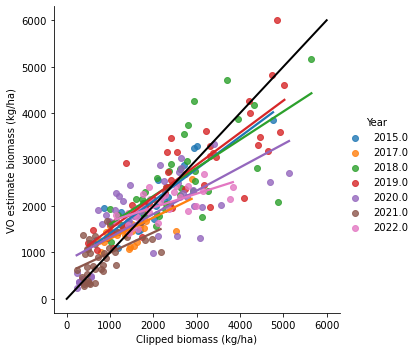

In [264]:
df_vor_mod['pred_tb_kg'] = df_vor_mod['pred_tb']*10
df_vor_mod['Total_Weight_(kg/ha)'] = df_vor_mod['Total_Weight_(g/m^2)']*10
sns.lmplot(y='pred_tb_kg',
           x='Total_Weight_(kg/ha)',
           data=df_vor_mod,
           hue='Year',
           order=1,
           ci=None,
           #line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
           #scatter_kws={'color': 'black', 's': 5}
          )
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('VO estimate biomass (kg/ha)')
plt.plot([0, 6000], [0, 6000], linewidth=2, c='black', linestyle='solid')

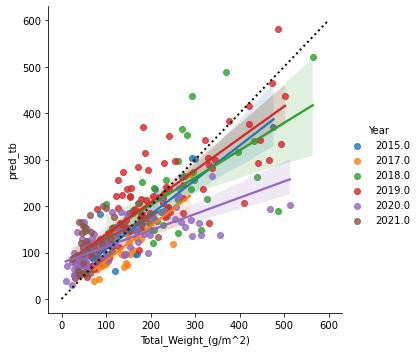

In [66]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(y='pred_tb',
           x='Total_Weight_(g/m^2)',
           hue='Year',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

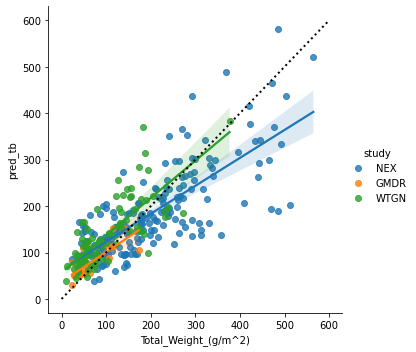

In [67]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(y='pred_tb',
           x='Total_Weight_(g/m^2)',
           hue='study',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

In [15]:
import pickle
with open('models/vor_linreg_both.pk', 'wb') as f:
    pickle.dump(mod_both, f)

### Things to try
* Covariate of precip (try a mixed model first as test)


In [124]:
import statsmodels.api as sm
mod_both_glm = smf.glm("Q('Total_Weight_(g/m^2)') ~ Low_cm + High_cm", data=df_vor, 
                       family=sm.families.Gamma(link=sm.genmod.families.links.identity())).fit()

/home/spkearney/miniconda3/envs/py_dataviz_env/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [125]:
mod_both_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     Q('Total_Weight_(g/m^2)')   No. Observations:                  256
Model:                                   GLM   Df Residuals:                      253
Model Family:                          Gamma   Df Model:                            2
Link Function:                      identity   Scale:                         0.25962
Method:                                 IRLS   Log-Likelihood:                -1389.7
Date:                       Fri, 22 Jul 2022   Deviance:                       75.845
Time:                               15:04:17   Pearson chi2:                     65.7
No. Iterations:                           25   Pseudo R-squ. (CS):             0.7955
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1966      4.508     -0.044      0.965      -9.033       8.640
Low_cm        10.2437      1.326      7.728      0.000       7.646      12.842
High_cm        1.7540      0.451      3.893      0.000       0.871       2.637
==============================================================================
"""

In [126]:
df_vor['pred_tb'] = mod_both_glm.predict()
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']

In [127]:
df_vor['pred_tb'].max()

493.50281059767036

In [128]:
shapiro(df_vor['resid_tb'])

ShapiroResult(statistic=0.95252925157547, pvalue=2.059997683545589e-07)

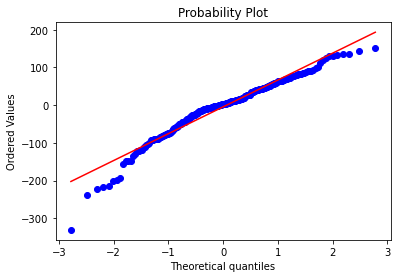

In [129]:
stats.probplot(df_vor['resid_tb'], dist="norm", plot=pylab)
pylab.show()

In [100]:
# relative RMSE
np.sqrt(df_vor.apply(lambda x: np.power(x['pred_tb'] - x['Total_Weight_(g/m^2)'], 
                                2), axis=1).mean()) / df_vor['Total_Weight_(g/m^2)'].mean()

0.955018778833943

In [101]:
#RMSE
np.sqrt(df_vor.apply(lambda x: np.power(x['pred_tb']*10 - x['Total_Weight_(g/m^2)']*10, 
                                2), axis=1).mean())

1342.6689342633063

In [102]:
df_vor.apply(lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']), axis=1).mean()

67.09961517570798

In [103]:
np.sqrt(df_vor.apply(lambda x: np.power(x['pred_cper'] - x['Total_Weight_(g/m^2)'], 
                                2), axis=1).mean()) / df_vor['Total_Weight_(g/m^2)'].mean()

0.5959735544305702

In [78]:
df_vor.apply(lambda x: abs(x['pred_cper'] - x['Total_Weight_(g/m^2)']), axis=1).mean()

64.3374051338322

eval_env: 1
eval_env: 1


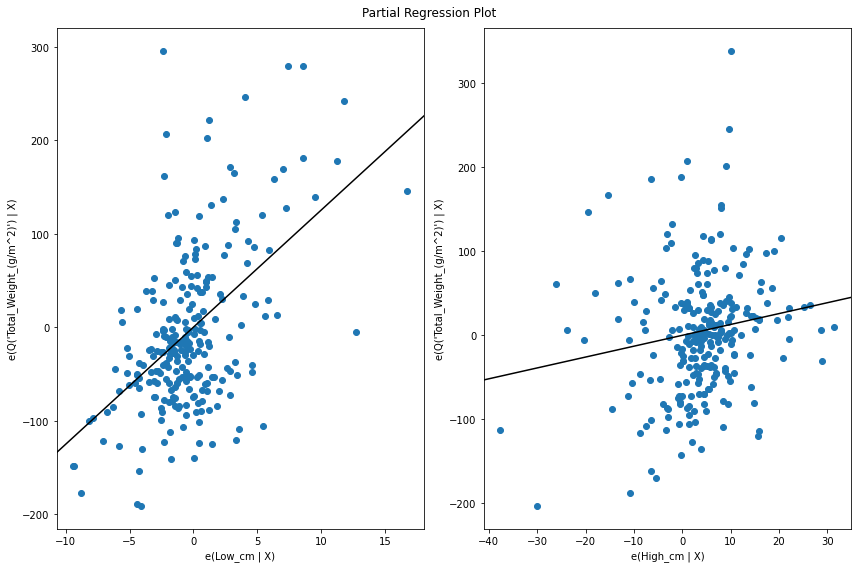

In [79]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_partregress_grid(mod_both, fig=fig)
fig.tight_layout(pad=1.0)

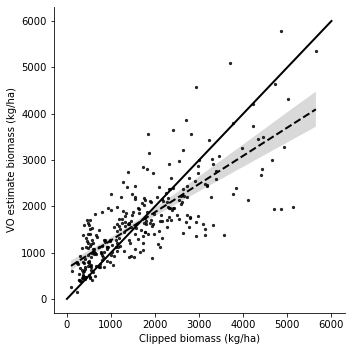

In [61]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
df_vor['pred_tb_kg'] = df_vor['pred_tb']*10
df_vor['Total_Weight_(kg/ha)'] = df_vor['Total_Weight_(g/m^2)']*10
sns.lmplot(y='pred_tb_kg',
           x='Total_Weight_(kg/ha)',
           data=df_vor,
           line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2},
           scatter_kws={'color': 'black', 's': 5})
plt.xlabel('Clipped biomass (kg/ha)')
plt.ylabel('VO estimate biomass (kg/ha)')
plt.plot([0, 6000], [0, 6000], linewidth=2, c='black', linestyle='solid')

In [36]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(y='pred_tb',
           x='Total_Weight_(g/m^2)',
           hue='Year',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

KeyError: 'pred_tb'

In [35]:
df_vor[(df_vor['Year']==2020) & (df_vor['Total_Weight_(g/m^2)'] < 50)]['study']

177    WTGN
178    WTGN
183    WTGN
185    WTGN
196    WTGN
197    WTGN
227    GMDR
228    GMDR
229    GMDR
230    WTGN
233    WTGN
234    WTGN
236    GMDR
237    GMDR
238    GMDR
239    GMDR
240    GMDR
241    WTGN
244    WTGN
250    WTGN
251    WTGN
253    WTGN
254    WTGN
255    WTGN
258    WTGN
259    WTGN
Name: study, dtype: object

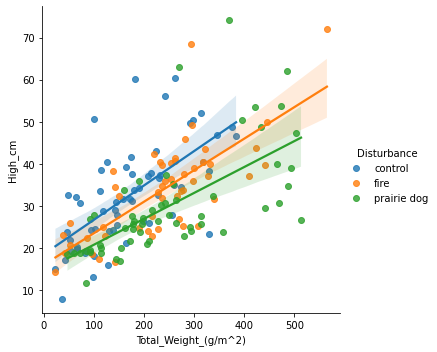

In [ ]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(y='High_cm',
           x='Total_Weight_(g/m^2)',
           hue='Disturbance',
           data=df_vor)
#plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

### other data
* there is VOR+clipping data from weight gain project, not ready yet (2019 might be ready, not sure about VOR, Elle is weighing 2020 data) - will prioritize 2019/2020 VOR
    * this will be the best VOR/Clipping data
    * 2019 - much of the VOR data won't be usable (but clipping is ok!). Lauren needs to figure out when date cut-off is for fix.
* Courtenay's bird habitat project has a ton of VOR data (30 m transects, since 2015) - can talk with David about this.
    * Clipping done a month later about 8 m away at subset of locations(60-80 locs)
* some other projects from 2014/2015 that Lauren can access
    * This would be nice to expand spatial coverage and burns
* USFS project in 2015/2016 - grid sampliing
    * not sure of their protocol (observations may be too limited)
    * data might be hard to access (a lot of people no longer there)

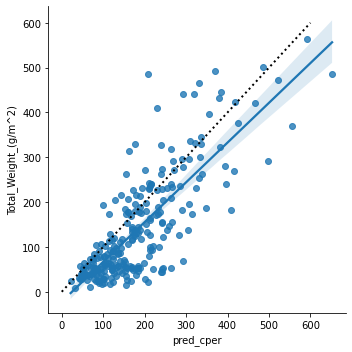

In [85]:
df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(x='pred_cper',
           y='Total_Weight_(g/m^2)',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

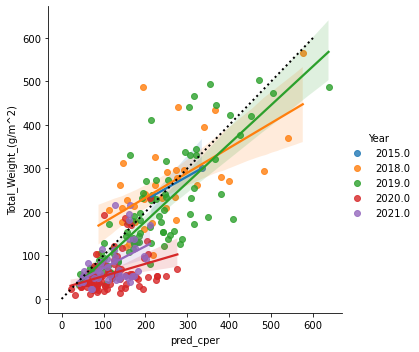

In [24]:
df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(x='pred_cper',
           y='Total_Weight_(g/m^2)',
           hue='Year',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

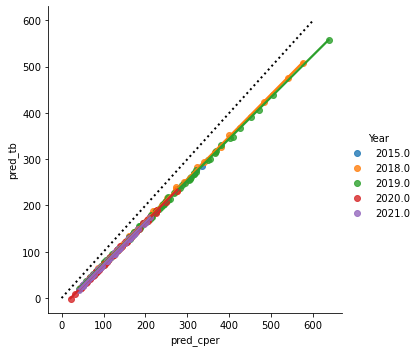

In [25]:
sns.lmplot(x='pred_cper',
           y='pred_tb',
           data=df_vor,
           hue='Year')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

In [26]:
(df_vor['pred_cper'] - df_vor['pred_tb']).max()

79.7160566644427

In [30]:
(df_vor['pred_cper'] - df_vor['pred_tb']).median()

31.423150150934987

In [28]:
(abs(df_vor['pred_cper'] - df_vor['pred_tb'])/df_vor['pred_tb']).mean()

0.2888055042034232